In [39]:
%load_ext autoreload
%autoreload 2

import numpy as np
from mopet import mopet

from synchronization import experiments
from synchronization import plots
from synchronization.experiments import MopetExampleExperiment

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Effect of uncorrelated noise on coupled EI networks

Hypothesis
* in certain parameter regimes the EI networks synchronize while within synchronization decreases
* only a fraction of the neurons in a network spike in each cycle, we see a widened voltage distribution

Setup
* 2 coupled network case
* independent noise with varying strengths

Metrics & Visualization
* overlap in peak frequency in power spectrum indicates synchronization
* local and global order parameter quantify synchronization respectively
* optional: mean phase coherence

Run for different noise strenghts and plot PSD spectra of all runs.
A handful of parameter sets should suffice to get a first intuition. Afterwards we can do an exhaustive parameter exploration.

In [40]:
factor = 1

# overwriting default parameters
default_params = {

  # synaptic coupling strengths, most important parameters for tuning PING mechanism
  # "J_itoi": 9. * factor,
  # "J_etoe": .4 * factor,
  # "J_etoi": 1.1 * factor,
  # "J_itoe": 10.0 * factor,

  "ou_enabled": [True, False],

  # Independent spike trains generated by Poisson Point Process for each target neuron
  "poisson_enabled": [False, True],
  "poisson_strength": 0.07,

   # noise frequency ration between networks
  "poisson_p": 1.0,
  # 50 Hz rate as in Meng et. al. and decreasing with network index
  "poisson_rates": [30, 40],
  "poisson_size": 200,
  "poisson_mean_input": 200, # mu = 200 Hz

  "J_ppee": 0.0,
  # increase from 0.1 to 0.2 increases mainly amplitude
  "J_ppei": 0.0,

  # if set to default of 0.1 this leads to strange split in frequency band
  "const_delay": 0.2,
  "N_pop": 2
}

params = {
    "J_etoe": np.arange(1, 2, 0.5),
}

In [45]:
ex = mopet.Exploration(
    experiments.run_network, 
    explore_params=params, 
    default_params=default_params
)

ex.run()
ex.load_results(all=True)

2020-05-29 10:47:30,556	INFO resource_spec.py:212 -- Starting Ray with 9.33 GiB memory available for workers and up to 4.67 GiB for objects. You can adjust these settings with ray.init(memory=<bytes>, object_store_memory=<bytes>).
2020-05-29 10:47:30,825	INFO services.py:1170 -- View the Ray dashboard at localhost:8265
  0%|          | 0/2 [00:00<?, ?it/s](pid=9315) /Users/lrebscher/git/Synchronization-by-Uncorrelated-Noise/models
(pid=9315) /Users/lrebscher/git/Synchronization-by-Uncorrelated-Noise/plots_out
(pid=9320) /Users/lrebscher/git/Synchronization-by-Uncorrelated-Noise/models
(pid=9320) /Users/lrebscher/git/Synchronization-by-Uncorrelated-Noise/plots_out
(pid=9315) Initializing net ...
(pid=9320) Initializing net ...
(pid=9320) Initialization time: 0.6253719329833984s
(pid=9315) Initialization time: 0.6214220523834229s
(pid=9315) ==== Running Network ... ====
(pid=9320) ==== Running Network ... ====
(pid=9320) WARNING    Note that the synaptic pathway 'synapses_10_pre' will ru

In [47]:
ex.explore_params
print(type(ex.results))
ex.results.keys()

<class 'dict'>


dict_keys([0, 1])

Generate PSD plot ...
Generate PSD plot ...
Generate PSD plot ...
Generate PSD plot ...


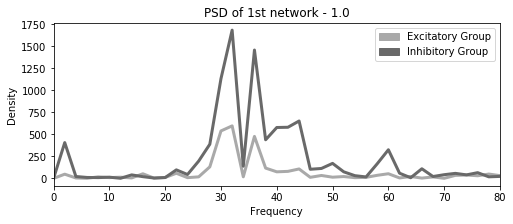

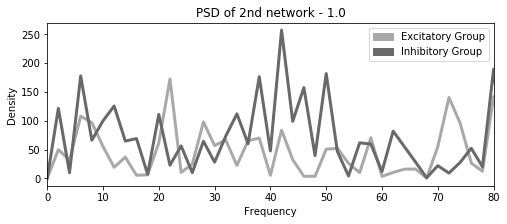

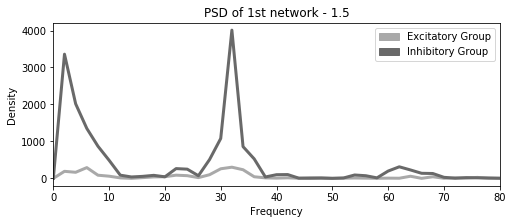

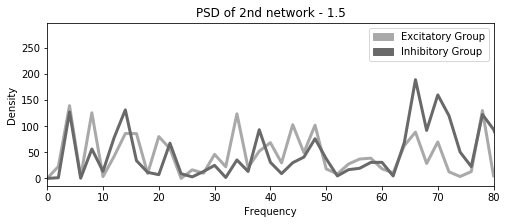

In [48]:
# TODOs:
# * Improve PSD plotting
# * calculate global and local order parameter for each run
# * compare coupled state with uncoupled state, uncoupled state acts as control group
# * with current EI network parameters we get a very scattered power spectrum, adjust parameters so that we get 1-3 main peaks in gamma band only.

for key, model in ex.results.items():
    row = ex.df.iloc[key]
    plots.psd(model, title=f"PSD of 1st network - {row['J_etoe']}", population=1, duration=1000)
    plots.psd(model, title=f"PSD of 2nd network - {row['J_etoe']}", population=2, duration=1000)

In [34]:
from synchronization import runner

results = runner.run()

Initializing net ...
Initialization time: 0.18253087997436523s
==== Running Network ... ====
Starting simulation at t=0. s for a duration of 0.5 s
0.5 s (100%) simulated in 2s
==== Network Run Finished ====
runtime: 2.3


In [42]:
for key, item in results.items():
    if item is None:
        print(key)
        print(item)

net_v_lower_bound
None
